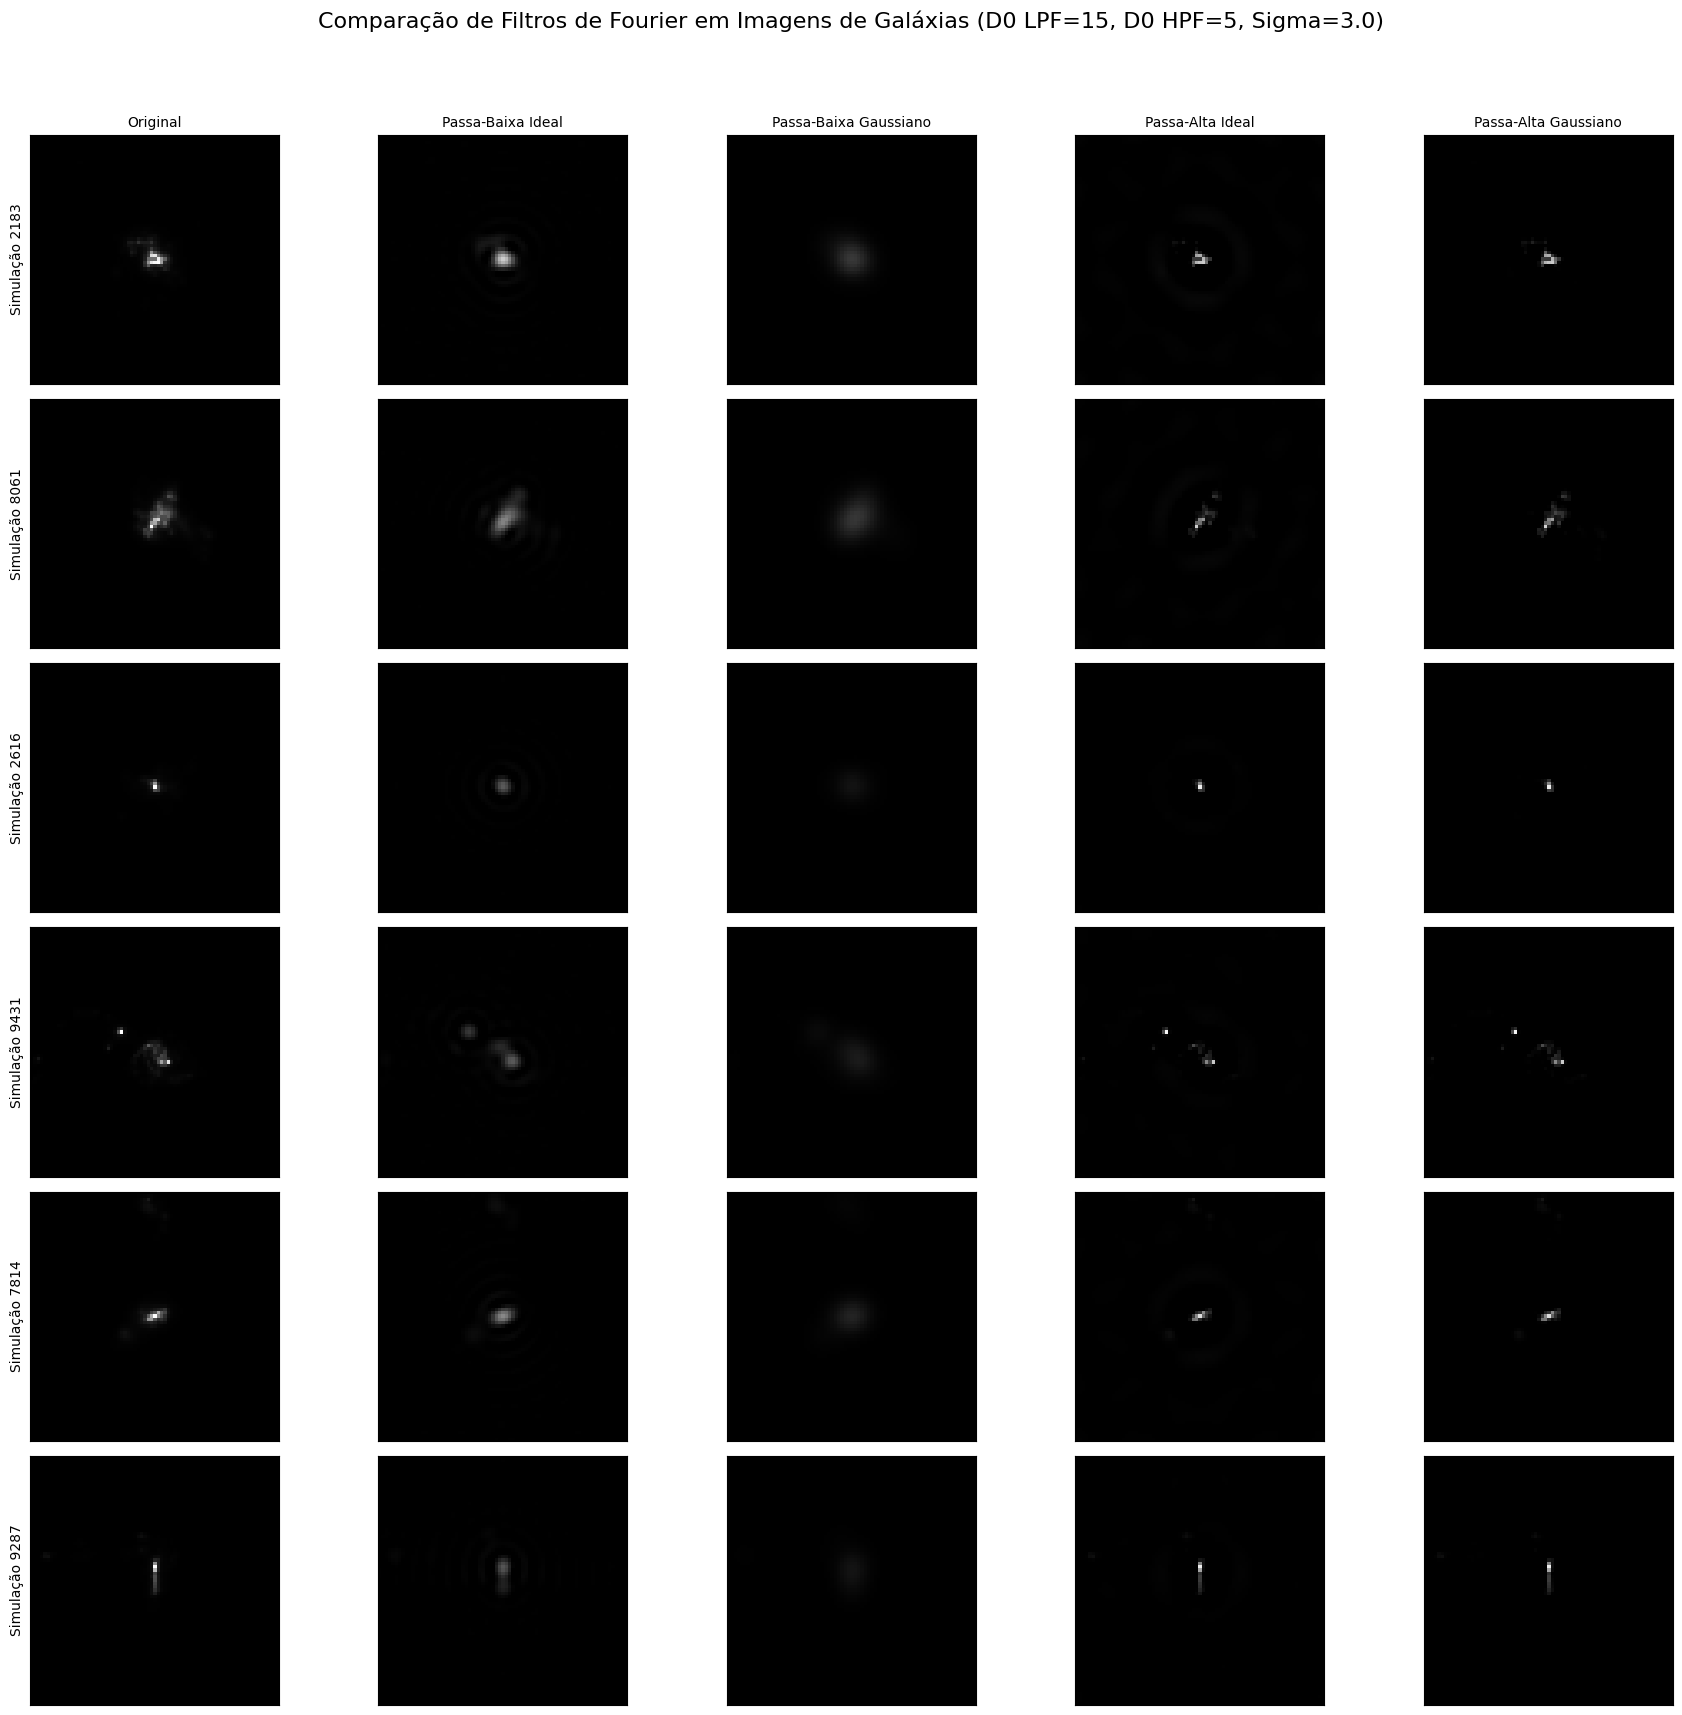

In [1]:
#Tratamento de imagens com filtros

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from skimage.filters import gaussian # scikit-image é útil para filtros de imagem

# Configurações
FITS_FILE = r"C:\Users\Cliente\Documents\Disciplinas Mestrado\PDS\hlsp_deepmerge_hst_acs-wfc3_illustris-z2_f814w-f160w_v1_sim-pristine.fits"
NUM_IMAGES_TO_PLOT = 6  # Número de imagens para visualização
D0_LPF = 15             # Raio de corte para Filtros Passa-Baixa (Suavização)
D0_HPF = 5              # Raio de corte para Filtros Passa-Alta (Realce)
SIGMA_GAUSS = 3.0       # Desvio padrão para Filtros Gaussianos
# Assumimos que o canal 0 é o de interesse
CHANNEL_INDEX = 0

# 1. Funções de Criação de Filtros (Domínio da Frequência)

def create_ideal_lowpass_filter(shape, D0):
    """Cria um filtro Passa-Baixa Ideal (Ideal Low Pass Filter - ILPF)."""
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.zeros(shape)
    for i in range(rows):
        for j in range(cols):
            D = np.sqrt((i - center_row)**2 + (j - center_col)**2)
            if D <= D0:
                mask[i, j] = 1
    return mask

def create_ideal_highpass_filter(shape, D0):
    """Cria um filtro Passa-Alta Ideal (Ideal High Pass Filter - IHPF)."""
    # HPF Ideal = 1 - LPF Ideal
    return 1 - create_ideal_lowpass_filter(shape, D0)

def apply_filter_fft(image_data, filter_mask):
    """Aplica o filtro na imagem usando a Transformada de Fourier."""
    # 1. FFT
    dft = np.fft.fft2(image_data)
    # 2. Shift (frequência zero para o centro)
    dft_shift = np.fft.fftshift(dft)
    
    # 3. Aplicação do filtro (Multiplicação no domínio da frequência)
    filtered_dft_shift = dft_shift * filter_mask
    
    # 4. Inverso do Shift
    dft_filtered = np.fft.ifftshift(filtered_dft_shift)
    # 5. IFFT (Transformada Inversa)
    image_filtered = np.fft.ifft2(dft_filtered)
    
    # Retorna apenas a parte real da IFFT
    return np.real(image_filtered)

# 2. Leitura dos Dados

try:
    with fits.open(FITS_FILE) as hdul:
        # Tenta pegar os dados da primeira extensão.
        # Ajuste hdul[0] ou hdul[1] se os dados estiverem em outra HDU.
        all_data = hdul[0].data
except FileNotFoundError:
    print(f"ERRO: Arquivo FITS não encontrado em: {FITS_FILE}")
    exit()

# Ajustar a dimensão para (N_simulações, N_canais, altura, largura)
if all_data.ndim == 4:
    # Selecionar apenas o canal de interesse de todas as simulações
    selected_images = all_data[:, CHANNEL_INDEX, :, :]
else:
    # Se o formato for diferente, o usuário precisará ajustar o `all_data`
    print(f"Atenção: O formato dos dados lidos é {all_data.shape}. Assumindo que o primeiro eixo é o das imagens.")
    selected_images = all_data 

N_total_images = selected_images.shape[0]
image_shape = selected_images.shape[1:]

if N_total_images < NUM_IMAGES_TO_PLOT:
    print("ERRO: O arquivo FITS tem menos imagens do que o número desejado para plotagem.")
    exit()

# Seleção aleatória de imagens
np.random.seed(42) # Para reprodutibilidade
random_indices = np.random.choice(N_total_images, NUM_IMAGES_TO_PLOT, replace=False)
images_to_process = selected_images[random_indices]

# 3. Criação das Máscaras de Filtro

# Máscaras Passa-Baixa e Passa-Alta
mask_ideal_lpf = create_ideal_lowpass_filter(image_shape, D0_LPF)
mask_ideal_hpf = create_ideal_highpass_filter(image_shape, D0_HPF)

# 4. Processamento, Plotagem e Comparação

fig, axes = plt.subplots(NUM_IMAGES_TO_PLOT, 5, figsize=(18, 3 * NUM_IMAGES_TO_PLOT))
plt.suptitle(f"Comparação de Filtros de Fourier em Imagens de Galáxias (D0 LPF={D0_LPF}, D0 HPF={D0_HPF}, Sigma={SIGMA_GAUSS})", fontsize=16)

# Títulos das Colunas
column_titles = ["Original", "Passa-Baixa Ideal", "Passa-Baixa Gaussiano", "Passa-Alta Ideal", "Passa-Alta Gaussiano"]

for i, original_image in enumerate(images_to_process):
    # Garante que os valores estejam normalizados para a visualização, se necessário
    # Usamos o `vmin` e `vmax` para manter a mesma escala de cor em todos os plots
    v_min, v_max = original_image.min(), original_image.max()

    # Aplicação dos Filtros 
    
    # 1. Passa-Baixa Ideal (ILPF)
    img_lpf_ideal = apply_filter_fft(original_image, mask_ideal_lpf)
    
    # 2. Passa-Baixa Gaussiano (Gauss LPF) - DOMÍNIO ESPACIAL
    # Para o Gaussiano, é mais comum e eficiente aplicar a convolução no domínio espacial.
    # O sigma é análogo ao raio de corte.
    img_lpf_gauss = gaussian(original_image, sigma=SIGMA_GAUSS, preserve_range=True)
    
    # 3. Passa-Alta Ideal (IHPF)
    img_hpf_ideal = apply_filter_fft(original_image, mask_ideal_hpf)
    
    # 4. Passa-Alta Gaussiano (Gauss HPF) - DOMÍNIO ESPACIAL
    # HPF Gaussiano = Original - LPF Gaussiano
    img_hpf_gauss = original_image - gaussian(original_image, sigma=SIGMA_GAUSS, preserve_range=True)
    
    # Lista de imagens para plotagem
    images = [original_image, img_lpf_ideal, img_lpf_gauss, img_hpf_ideal, img_hpf_gauss]

    # Plotagem 
    for j, img in enumerate(images):
        ax = axes[i, j]
        im = ax.imshow(img, cmap='gray', vmin=v_min, vmax=v_max)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if i == 0:
            ax.set_title(column_titles[j], fontsize=10)
        
        if j == 0:
            ax.set_ylabel(f"Simulação {random_indices[i]}", fontsize=10)

# Ajuste automático do layout e exibição
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show() 

# Para uma análise mais robusta, você também pode plotar o espectro de magnitude 
# de uma das imagens, juntamente com o filtro, para entender o efeito no domínio da frequência.

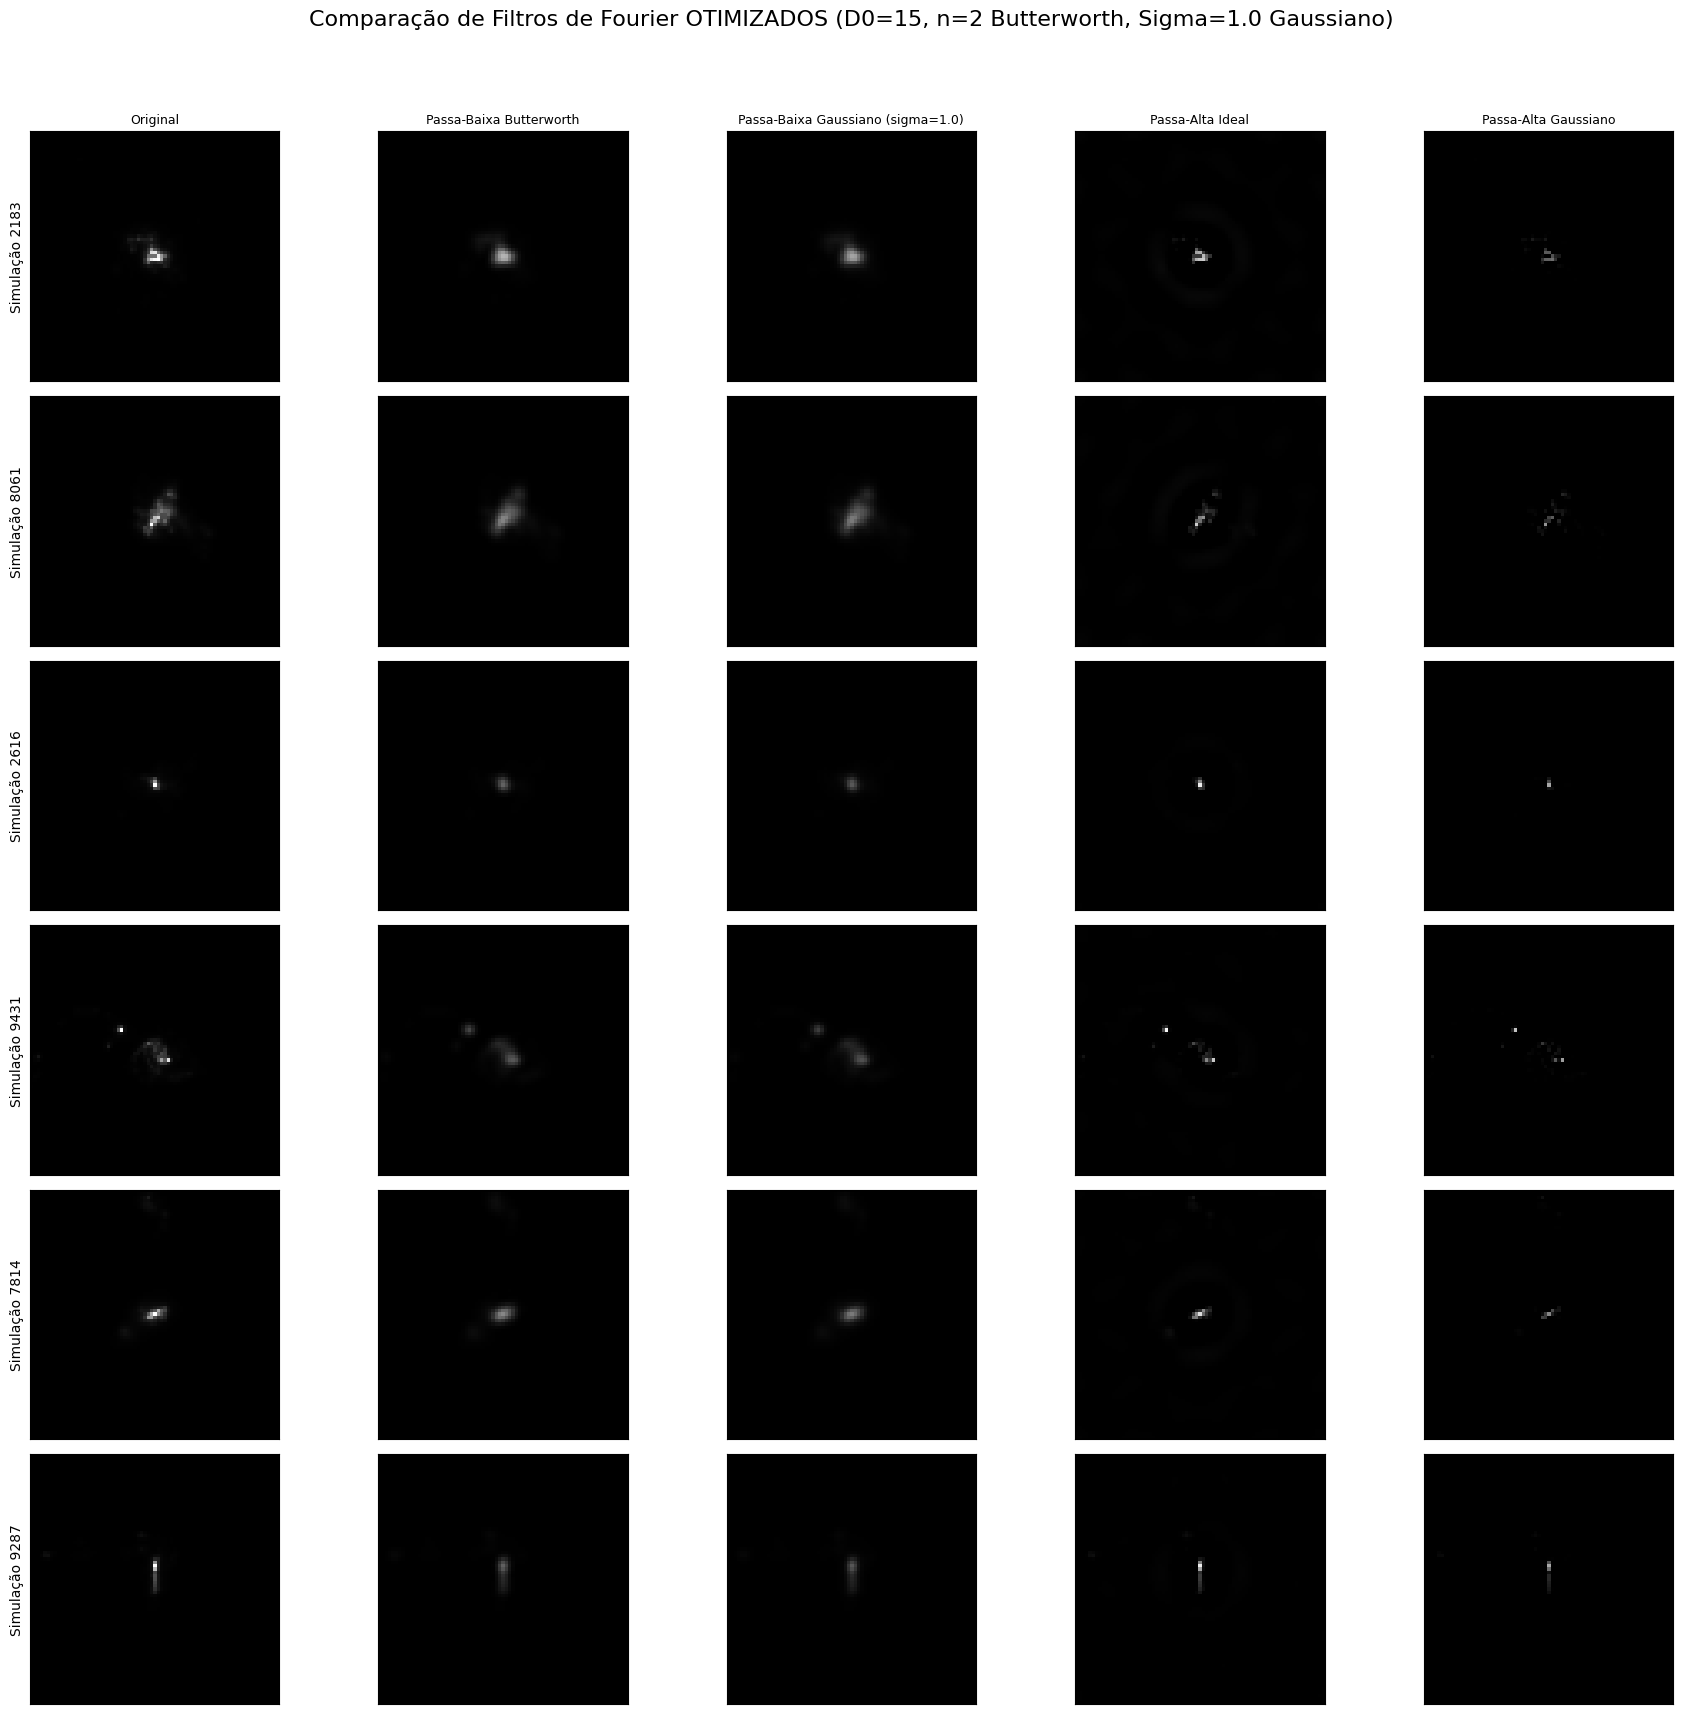

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from skimage.filters import gaussian # scikit-image é útil para filtros de imagem

# --- Configurações ---
FITS_FILE = r"C:\Users\Cliente\Documents\Disciplinas Mestrado\PDS\hlsp_deepmerge_hst_acs-wfc3_illustris-z2_f814w-f160w_v1_sim-pristine.fits"
NUM_IMAGES_TO_PLOT = 6  # Número de imagens para visualização
D0_LPF = 15             # Raio de corte para Filtros Passa-Baixa (Butterworth)
N_BUTTERWORTH = 2       # Ordem do Filtro de Butterworth (Recomendado n=2)
SIGMA_GAUSS = 1.0       # Desvio padrão ajustado para Filtro Gaussiano (Menos agressivo)
D0_HPF = 5              # Raio de corte para Filtros Passa-Alta
CHANNEL_INDEX = 0

# --------------------------------------------------------------------------
## Funções de Criação de Filtros (Domínio da Frequência)

def create_butterworth_lowpass_filter(shape, D0, n):
    """Cria um filtro Passa-Baixa de Butterworth (BTLPF)."""
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.zeros(shape)
    
    # Prepara a grade de coordenadas para calcular a distância
    u, v = np.mgrid[0:rows, 0:cols]
    D = np.sqrt((u - center_row)**2 + (v - center_col)**2)
    
    # Fórmula do Filtro de Butterworth Passa-Baixa
    mask = 1 / (1 + (D / D0)**(2 * n))
    return mask

def create_ideal_highpass_filter(shape, D0):
    """Cria um filtro Passa-Alta Ideal (IHPF) - Mantido para comparação."""
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.zeros(shape)
    for i in range(rows):
        for j in range(cols):
            D = np.sqrt((i - center_row)**2 + (j - center_col)**2)
            if D > D0:
                mask[i, j] = 1 
    return mask

def apply_filter_fft(image_data, filter_mask):
    """Aplica o filtro na imagem usando a Transformada de Fourier."""
    dft = np.fft.fft2(image_data)
    dft_shift = np.fft.fftshift(dft)
    
    # Aplicação do filtro
    filtered_dft_shift = dft_shift * filter_mask
    
    dft_filtered = np.fft.ifftshift(filtered_dft_shift)
    image_filtered = np.fft.ifft2(dft_filtered)
    
    return np.real(image_filtered)

# --------------------------------------------------------------------------
## Leitura dos Dados

try:
    with fits.open(FITS_FILE) as hdul:
        all_data = hdul[0].data
except FileNotFoundError:
    print(f"ERRO: Arquivo FITS não encontrado em: {FITS_FILE}")
    exit()

if all_data.ndim == 4:
    selected_images = all_data[:, CHANNEL_INDEX, :, :]
else:
    print(f"Atenção: O formato dos dados lidos é {all_data.shape}. Assumindo que o primeiro eixo é o das imagens.")
    selected_images = all_data 

N_total_images = selected_images.shape[0]
image_shape = selected_images.shape[1:]

if N_total_images < NUM_IMAGES_TO_PLOT:
    print("ERRO: O arquivo FITS tem menos imagens do que o número desejado para plotagem.")
    exit()

# Seleção aleatória de imagens
np.random.seed(42) # Para reprodutibilidade
random_indices = np.random.choice(N_total_images, NUM_IMAGES_TO_PLOT, replace=False)
images_to_process = selected_images[random_indices]

# --------------------------------------------------------------------------
## Criação das Máscaras de Filtro Otimizadas

# Nova Máscara Passa-Baixa de Butterworth
mask_butterworth_lpf = create_butterworth_lowpass_filter(image_shape, D0_LPF, N_BUTTERWORTH)
# Mantido Ideal HPF para comparação de realce
mask_ideal_hpf = create_ideal_highpass_filter(image_shape, D0_HPF)

# --------------------------------------------------------------------------
## Processamento, Plotagem e Comparação Otimizados

fig, axes = plt.subplots(NUM_IMAGES_TO_PLOT, 5, figsize=(18, 3 * NUM_IMAGES_TO_PLOT))
plt.suptitle(f"Comparação de Filtros de Fourier OTIMIZADOS (D0={D0_LPF}, n={N_BUTTERWORTH} Butterworth, Sigma={SIGMA_GAUSS} Gaussiano)", fontsize=16)

# Títulos das Colunas Atualizados
column_titles = ["Original", "Passa-Baixa Butterworth", "Passa-Baixa Gaussiano (sigma=1.0)", "Passa-Alta Ideal", "Passa-Alta Gaussiano"]

for i, original_image in enumerate(images_to_process):
    # Definindo a escala de cor para todas as imagens na linha
    v_min, v_max = original_image.min(), original_image.max()

    # --- Aplicação dos Filtros Otimizados ---
    
    # 1. Passa-Baixa Butterworth (BTLPF)
    img_lpf_butterworth = apply_filter_fft(original_image, mask_butterworth_lpf)
    
    # 2. Passa-Baixa Gaussiano (Gauss LPF) - Sigma ajustado para 1.0
    img_lpf_gauss = gaussian(original_image, sigma=SIGMA_GAUSS, preserve_range=True)
    
    # 3. Passa-Alta Ideal (IHPF) - Mantido
    img_hpf_ideal = apply_filter_fft(original_image, mask_ideal_hpf)
    
    # 4. Passa-Alta Gaussiano (Gauss HPF) - Sigma ajustado para 1.0
    img_hpf_gauss = original_image - gaussian(original_image, sigma=SIGMA_GAUSS, preserve_range=True)
    
    # Lista de imagens para plotagem
    images = [original_image, img_lpf_butterworth, img_lpf_gauss, img_hpf_ideal, img_hpf_gauss]

    # --- Plotagem ---
    for j, img in enumerate(images):
        ax = axes[i, j]
        ax.imshow(img, cmap='gray', vmin=v_min, vmax=v_max)
        ax.set_xticks([])
        ax.set_yticks([])
        
        if i == 0:
            ax.set_title(column_titles[j], fontsize=9) # Fonte menor devido a títulos maiores
        
        if j == 0:
            ax.set_ylabel(f"Simulação {random_indices[i]}", fontsize=10)

# Ajuste automático do layout e exibição
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

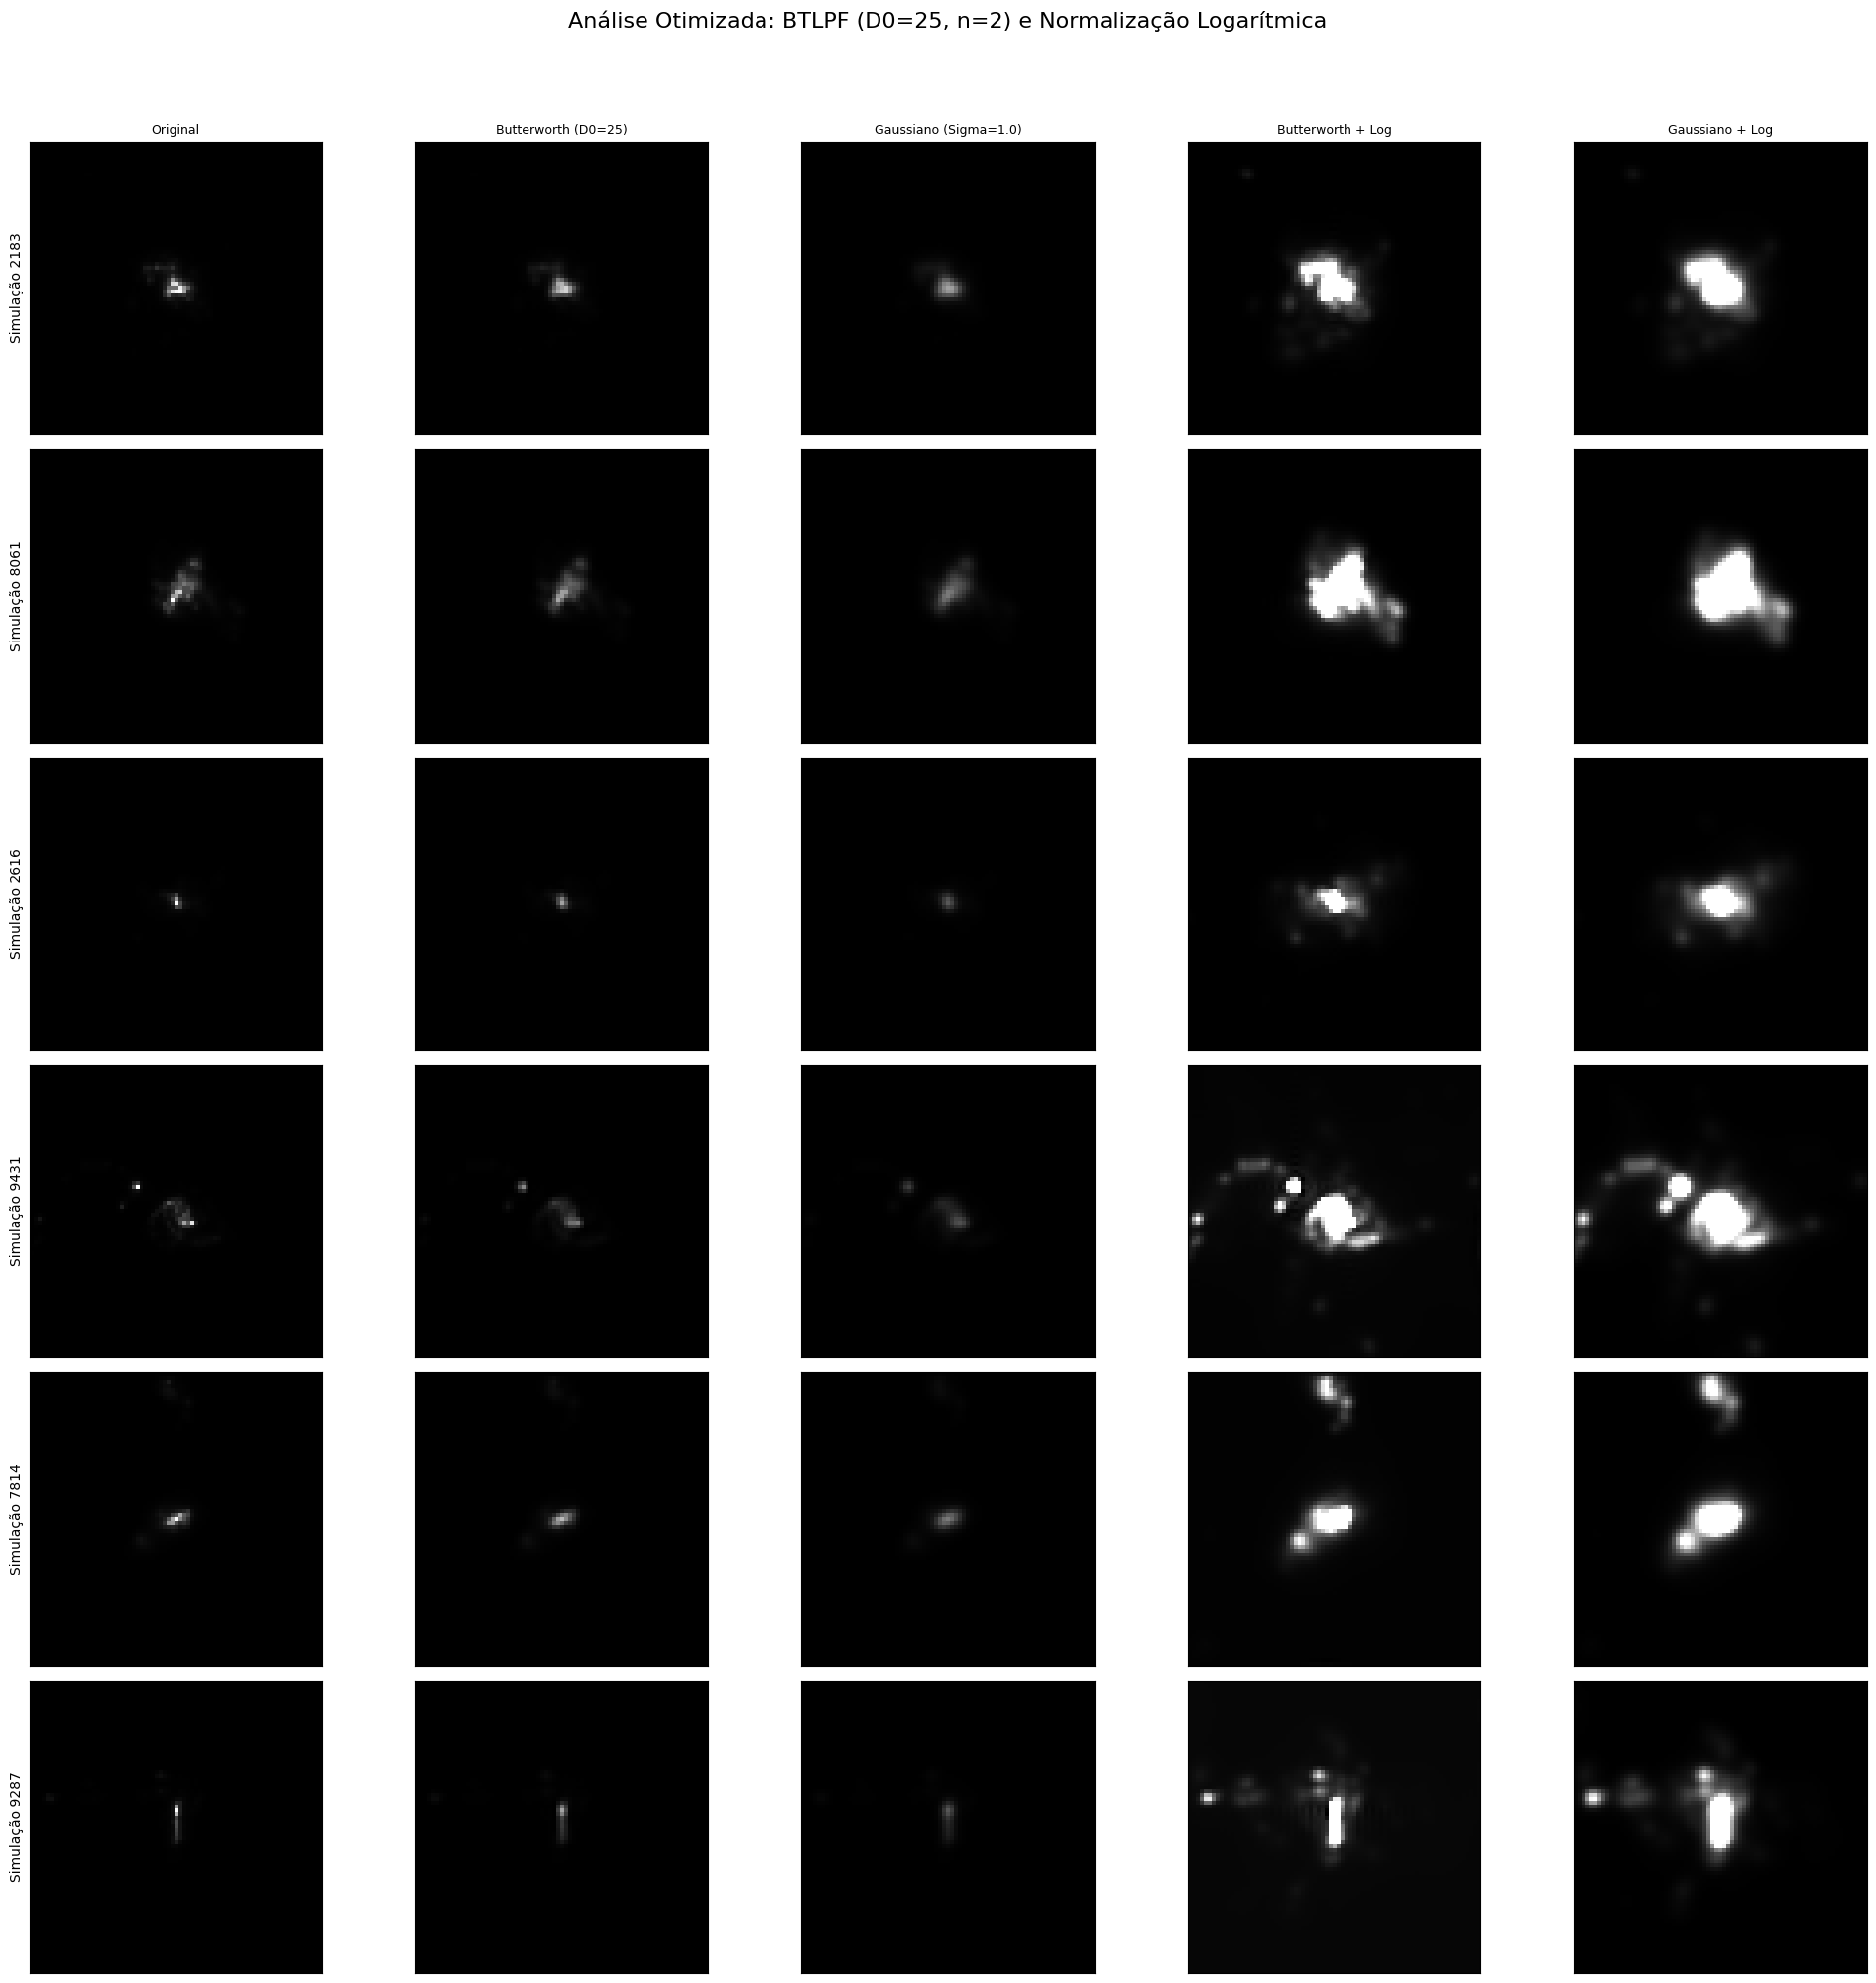

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from skimage.filters import gaussian
from skimage import exposure # Biblioteca para ajuste de contraste/exposição

# --- Configurações ---
FITS_FILE = r"C:\Users\Cliente\Documents\Disciplinas Mestrado\PDS\hlsp_deepmerge_hst_acs-wfc3_illustris-z2_f814w-f160w_v1_sim-pristine.fits"
NUM_IMAGES_TO_PLOT = 6  
# Novos parâmetros otimizados:
D0_BUTTERWORTH = 25     # Raio de corte aumentado para reter mais detalhes (menos agressivo)
N_BUTTERWORTH = 2       # Ordem do Filtro de Butterworth (transição suave)
SIGMA_GAUSS = 1.0       # Desvio padrão para Filtro Gaussiano
CHANNEL_INDEX = 0

# --------------------------------------------------------------------------
## Funções de Criação de Filtros e FFT

def create_butterworth_lowpass_filter(shape, D0, n):
    """Cria um filtro Passa-Baixa de Butterworth (BTLPF)."""
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2
    
    u, v = np.mgrid[0:rows, 0:cols]
    D = np.sqrt((u - center_row)**2 + (v - center_col)**2)
    
    # Fórmula BTLPF: 1 / (1 + (D/D0)^(2n))
    mask = 1 / (1 + (D / D0)**(2 * n))
    return mask

def apply_filter_fft(image_data, filter_mask):
    """Aplica o filtro na imagem usando a Transformada de Fourier."""
    dft = np.fft.fft2(image_data)
    dft_shift = np.fft.fftshift(dft)
    
    filtered_dft_shift = dft_shift * filter_mask
    
    dft_filtered = np.fft.ifftshift(filtered_dft_shift)
    image_filtered = np.fft.ifft2(dft_filtered)
    
    return np.real(image_filtered)

def apply_log_normalization(image):
    """Aplica a normalização logarítmica para aumentar o contraste."""
    # 1. Normaliza a imagem para o intervalo [0, 1]
    img_norm = (image - image.min()) / (image.max() - image.min())
    
    # 2. Aplica a transformação logarítmica: c * log(1 + x)
    # exposure.adjust_log é uma forma robusta de fazer isso.
    # O valor 10 é o fator de ganho/gamma. Ajuste para maior contraste se necessário.
    img_log_stretched = exposure.adjust_log(img_norm, gain=10)
    
    return img_log_stretched

# --------------------------------------------------------------------------
## Leitura e Seleção de Dados

try:
    with fits.open(FITS_FILE) as hdul:
        all_data = hdul[0].data
except FileNotFoundError:
    print(f"ERRO: Arquivo FITS não encontrado em: {FITS_FILE}")
    exit()

if all_data.ndim == 4:
    selected_images = all_data[:, CHANNEL_INDEX, :, :]
else:
    selected_images = all_data 

N_total_images = selected_images.shape[0]
image_shape = selected_images.shape[1:]

if N_total_images < NUM_IMAGES_TO_PLOT:
    print("ERRO: O arquivo FITS tem menos imagens do que o número desejado para plotagem.")
    exit()

np.random.seed(42)
random_indices = np.random.choice(N_total_images, NUM_IMAGES_TO_PLOT, replace=False)
images_to_process = selected_images[random_indices]

# --------------------------------------------------------------------------
## Criação das Máscaras de Filtro

mask_butterworth_lpf = create_butterworth_lowpass_filter(image_shape, D0_BUTTERWORTH, N_BUTTERWORTH)

# --------------------------------------------------------------------------
## Processamento, Plotagem e Comparação Otimizados

# Total de colunas: Original, 2 Passa-Baixa, e 2 Pós-processadas
fig, axes = plt.subplots(NUM_IMAGES_TO_PLOT, 5, figsize=(20, 3.5 * NUM_IMAGES_TO_PLOT))
plt.suptitle(f"Análise Otimizada: BTLPF (D0={D0_BUTTERWORTH}, n={N_BUTTERWORTH}) e Normalização Logarítmica", fontsize=16)

column_titles = [
    "Original", 
    f"Butterworth (D0={D0_BUTTERWORTH})", 
    f"Gaussiano (Sigma={SIGMA_GAUSS})",
    "Butterworth + Log",
    "Gaussiano + Log"
]

for i, original_image in enumerate(images_to_process):
    
    # Filtragem
    img_lpf_butterworth = apply_filter_fft(original_image, mask_butterworth_lpf)
    img_lpf_gauss = gaussian(original_image, sigma=SIGMA_GAUSS, preserve_range=True)
    
    # Pós-processamento (Normalização Logarítmica)
    img_butterworth_log = apply_log_normalization(img_lpf_butterworth)
    img_gauss_log = apply_log_normalization(img_lpf_gauss)
    
    # Lista de imagens para plotagem
    images = [
        original_image, 
        img_lpf_butterworth, 
        img_lpf_gauss, 
        img_butterworth_log,
        img_gauss_log
    ]
    
    # Definindo a escala de cor (vmin/vmax)
    # Apenas as colunas 0, 1 e 2 usam a escala de brilho original
    v_min_orig, v_max_orig = original_image.min(), original_image.max()
    
    # --- Plotagem ---
    for j, img in enumerate(images):
        ax = axes[i, j]
        
        # As imagens logarítmicas (colunas 3 e 4) já estão normalizadas para [0, 1]
        if j < 3:
            im = ax.imshow(img, cmap='gray', vmin=v_min_orig, vmax=v_max_orig)
        else:
            # Imagens Log já tem o contraste ajustado para visualização
            im = ax.imshow(img, cmap='gray', vmin=0, vmax=1)
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        if i == 0:
            ax.set_title(column_titles[j], fontsize=9)
        
        if j == 0:
            ax.set_ylabel(f"Simulação {random_indices[i]}", fontsize=10)

# Ajuste automático do layout e exibição
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

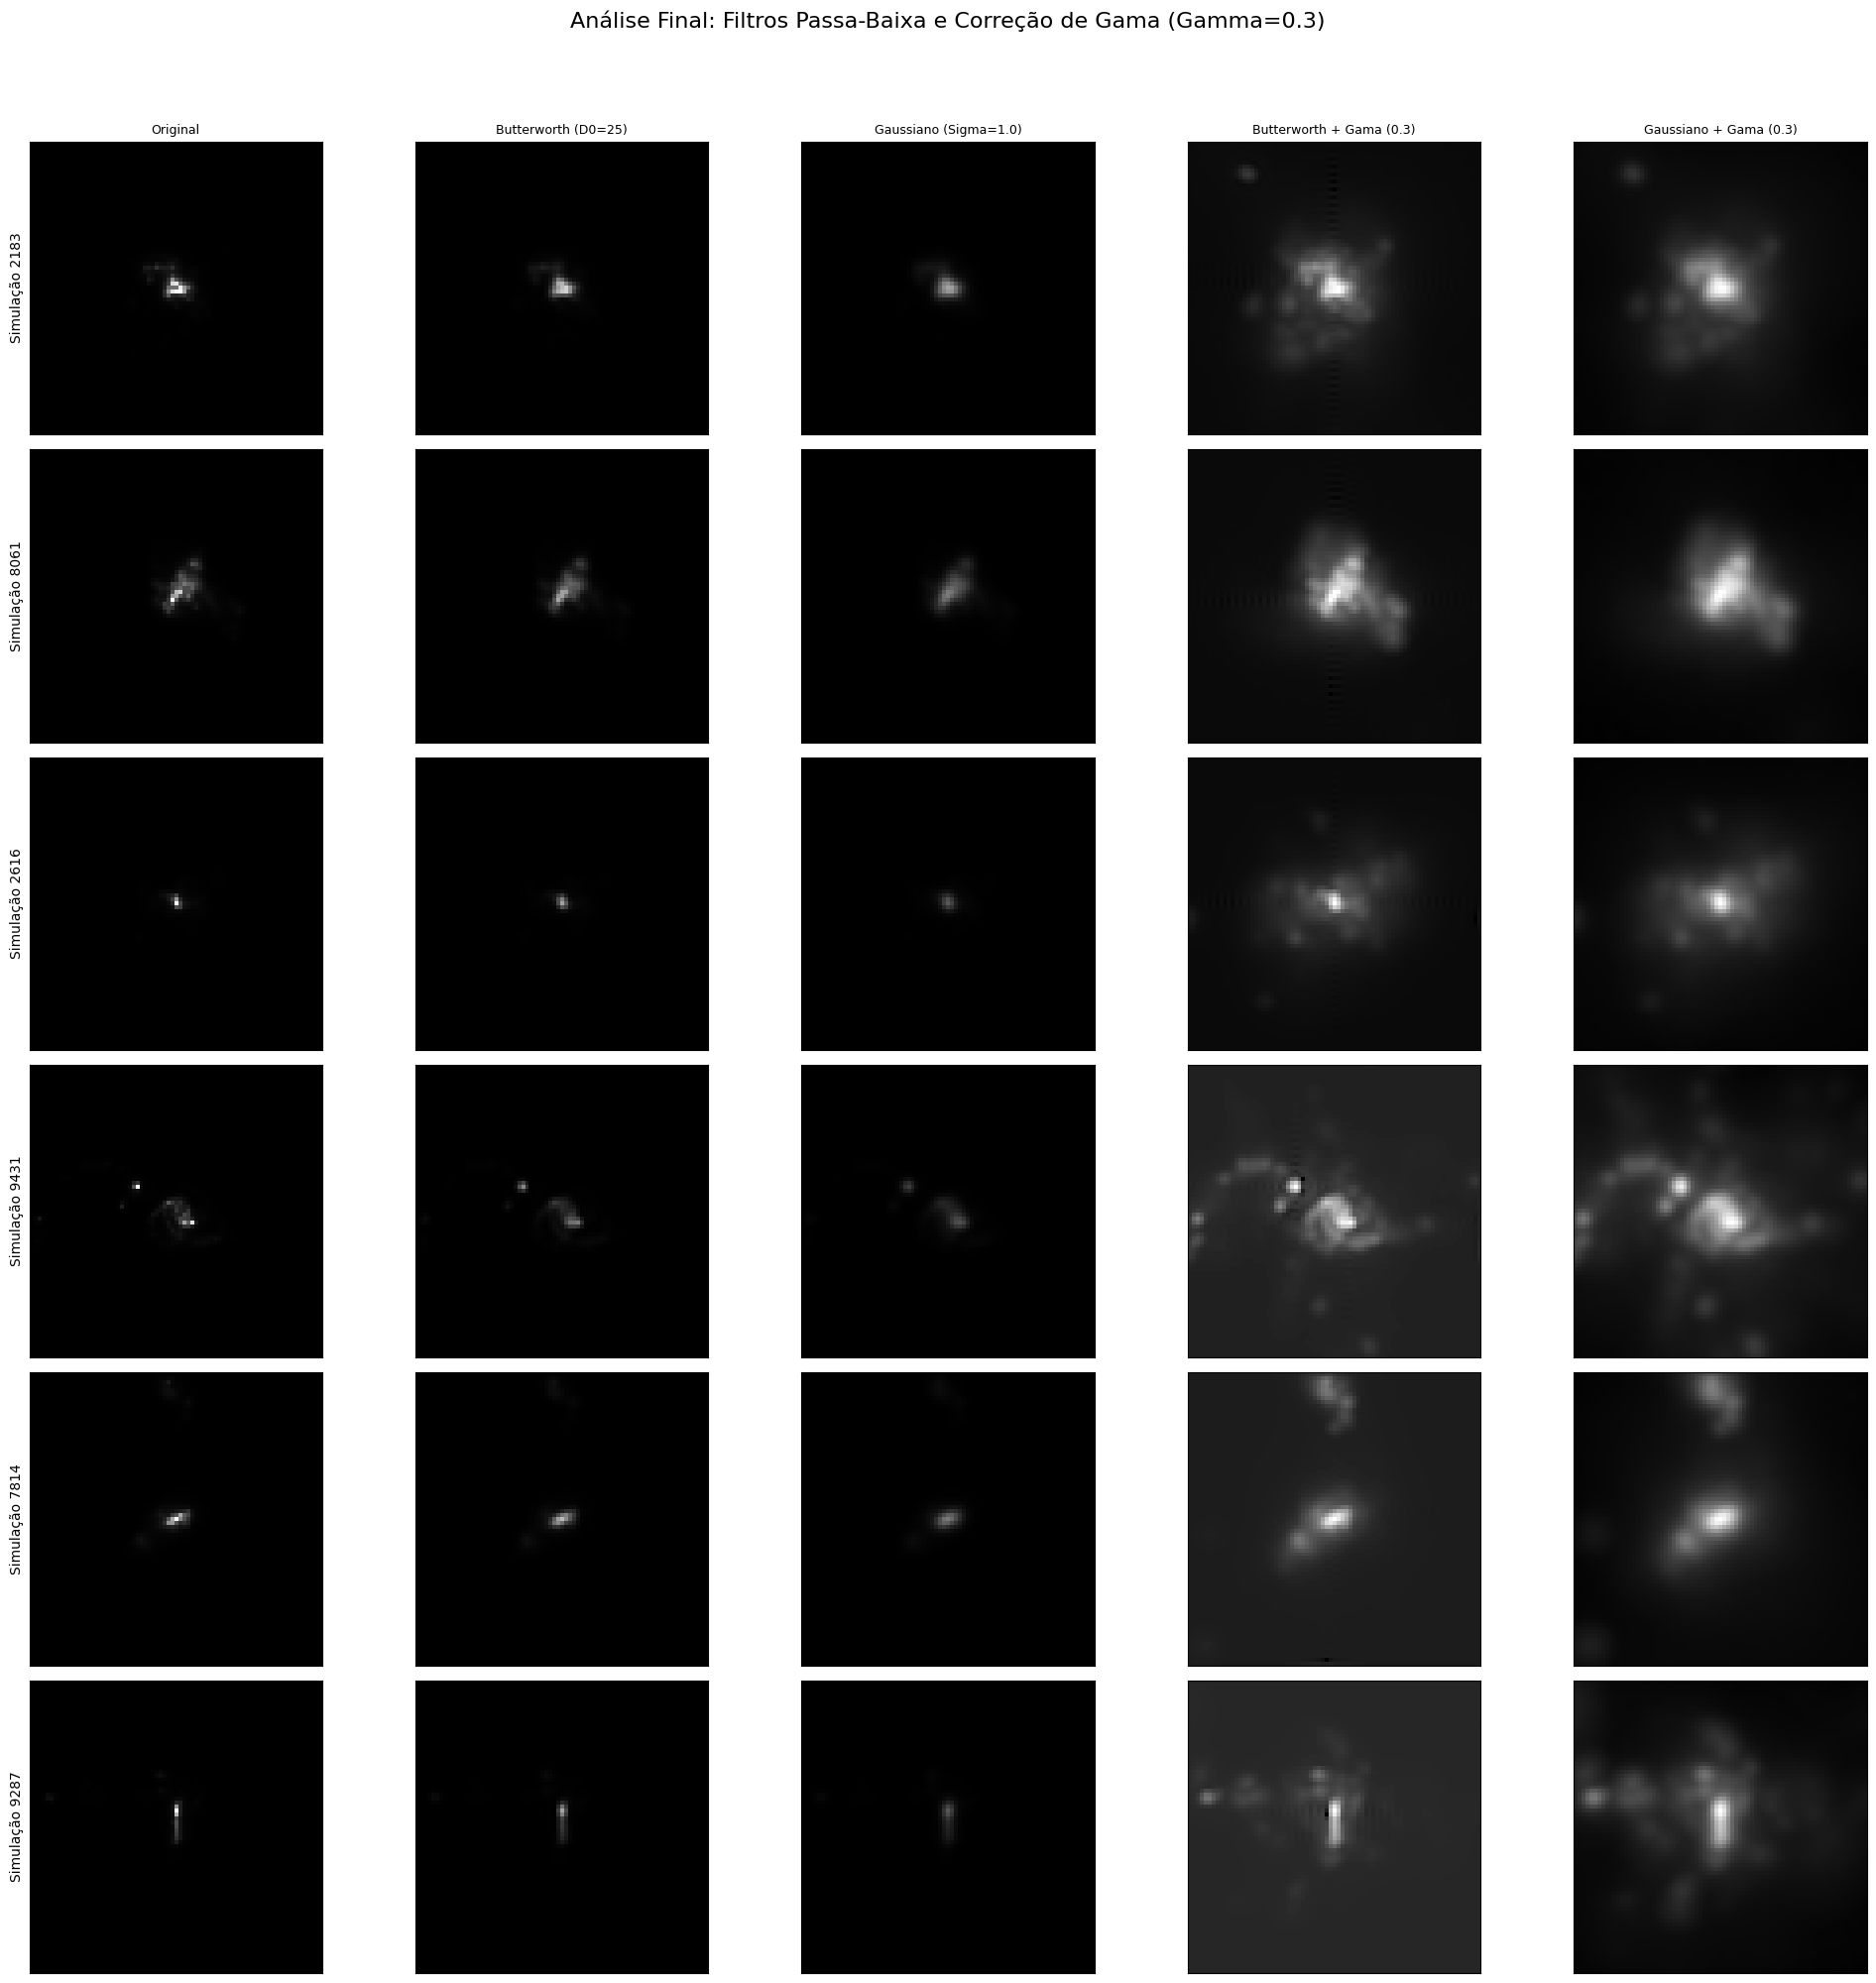

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from skimage.filters import gaussian
from skimage import exposure 

# --- Configurações ---
FITS_FILE = r"C:\Users\Cliente\Documents\Disciplinas Mestrado\PDS\hlsp_deepmerge_hst_acs-wfc3_illustris-z2_f814w-f160w_v1_sim-pristine.fits"
NUM_IMAGES_TO_PLOT = 6  
# Parâmetros Passa-Baixa Otimizados
D0_BUTTERWORTH = 25     
N_BUTTERWORTH = 2       
SIGMA_GAUSS = 1.0       
# Parâmetro de Pós-Processamento Otimizado
GAMMA_CORRECTION = 0.3  # Valor < 1 para iluminar áreas escuras e aumentar contraste
CHANNEL_INDEX = 0

# --------------------------------------------------------------------------
## Funções de Filtro

def create_butterworth_lowpass_filter(shape, D0, n):
    """Cria um filtro Passa-Baixa de Butterworth (BTLPF)."""
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2
    
    u, v = np.mgrid[0:rows, 0:cols]
    D = np.sqrt((u - center_row)**2 + (v - center_col)**2)
    
    mask = 1 / (1 + (D / D0)**(2 * n))
    return mask

def apply_filter_fft(image_data, filter_mask):
    """Aplica o filtro na imagem usando a Transformada de Fourier."""
    dft = np.fft.fft2(image_data)
    dft_shift = np.fft.fftshift(dft)
    
    filtered_dft_shift = dft_shift * filter_mask
    
    dft_filtered = np.fft.ifftshift(filtered_dft_shift)
    image_filtered = np.fft.ifft2(dft_filtered)
    
    return np.real(image_filtered)

def apply_gamma_correction(image, gamma):
    """Aplica a Correção de Gama para ajustar o contraste."""
    # Primeiro, normaliza a imagem para o intervalo [0, 1]
    img_norm = (image - image.min()) / (image.max() - image.min())
    
    # Aplica a correção de Gama: img_norm ^ gamma
    img_gamma_corrected = exposure.adjust_gamma(img_norm, gamma)
    
    return img_gamma_corrected

# --------------------------------------------------------------------------
## Leitura e Seleção de Dados (Mantido)

try:
    with fits.open(FITS_FILE) as hdul:
        all_data = hdul[0].data
except FileNotFoundError:
    print(f"ERRO: Arquivo FITS não encontrado em: {FITS_FILE}")
    exit()

if all_data.ndim == 4:
    selected_images = all_data[:, CHANNEL_INDEX, :, :]
else:
    selected_images = all_data 

N_total_images = selected_images.shape[0]
image_shape = selected_images.shape[1:]

if N_total_images < NUM_IMAGES_TO_PLOT:
    print("ERRO: O arquivo FITS tem menos imagens do que o número desejado para plotagem.")
    exit()

np.random.seed(42)
random_indices = np.random.choice(N_total_images, NUM_IMAGES_TO_PLOT, replace=False)
images_to_process = selected_images[random_indices]

# --------------------------------------------------------------------------
## Criação das Máscaras de Filtro

mask_butterworth_lpf = create_butterworth_lowpass_filter(image_shape, D0_BUTTERWORTH, N_BUTTERWORTH)

# --------------------------------------------------------------------------
## Processamento, Plotagem e Comparação Final 🎨

# Total de colunas: Original, 2 Passa-Baixa (Pós-FFT), e 2 Pós-processadas (Pós-Gama)
fig, axes = plt.subplots(NUM_IMAGES_TO_PLOT, 5, figsize=(20, 3.5 * NUM_IMAGES_TO_PLOT))
plt.suptitle(f"Análise Final: Filtros Passa-Baixa e Correção de Gama (Gamma={GAMMA_CORRECTION})", fontsize=16)

column_titles = [
    "Original", 
    f"Butterworth (D0={D0_BUTTERWORTH})", 
    f"Gaussiano (Sigma={SIGMA_GAUSS})",
    f"Butterworth + Gama ({GAMMA_CORRECTION})",
    f"Gaussiano + Gama ({GAMMA_CORRECTION})"
]

for i, original_image in enumerate(images_to_process):
    
    # 1. Filtragem
    img_lpf_butterworth = apply_filter_fft(original_image, mask_butterworth_lpf)
    img_lpf_gauss = gaussian(original_image, sigma=SIGMA_GAUSS, preserve_range=True)
    
    # 2. Pós-processamento (Correção de Gama)
    img_butterworth_gamma = apply_gamma_correction(img_lpf_butterworth, GAMMA_CORRECTION)
    img_gauss_gamma = apply_gamma_correction(img_lpf_gauss, GAMMA_CORRECTION)
    
    # Lista de imagens para plotagem
    images = [
        original_image, 
        img_lpf_butterworth, 
        img_lpf_gauss, 
        img_butterworth_gamma,
        img_gauss_gamma
    ]
    
    # Definindo a escala de cor (vmin/vmax)
    # Colunas 0, 1 e 2 usam a escala de brilho original
    v_min_orig, v_max_orig = original_image.min(), original_image.max()
    
    # --- Plotagem ---
    for j, img in enumerate(images):
        ax = axes[i, j]
        
        # As imagens Gama (colunas 3 e 4) já estão visualmente otimizadas
        if j < 3:
            # Mantém a escala original para estas colunas
            im = ax.imshow(img, cmap='gray', vmin=v_min_orig, vmax=v_max_orig)
        else:
            # Permite que a escala de cor se ajuste automaticamente (vmin=0, vmax=1)
            im = ax.imshow(img, cmap='gray')
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        if i == 0:
            ax.set_title(column_titles[j], fontsize=9)
        
        if j == 0:
            ax.set_ylabel(f"Simulação {random_indices[i]}", fontsize=10)

# Ajuste automático do layout e exibição
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
#Aqui começa o código que está otimizado

In [1]:
import numpy as np
import matplotlib.pyplot as plt # Mantido para fins de depuração/visualização (opcional)
from astropy.io import fits
from skimage.exposure import adjust_gamma # Para a Correção de Gama

# 1. CONFIGURAÇÕES GLOBAIS

FITS_FILE = r"C:\Users\Cliente\Documents\Disciplinas Mestrado\PDS\hlsp_deepmerge_hst_acs-wfc3_illustris-z2_f814w-f160w_v1_sim-pristine.fits"

# Parâmetros Otimizados
D0_BUTTERWORTH = 25     # Raio de corte do Butterworth
N_BUTTERWORTH = 2       # Ordem do filtro
GAMMA_CORRECTION = 0.3  # Fator de Gama para aumentar contraste (iluminar sombras)
CHANNEL_INDEX = 0       # Canal de interesse no arquivo FITS

# 2. FUNÇÕES DE FILTRAGEM E PÓS-PROCESSAMENTO

def create_butterworth_lowpass_filter(shape, D0, n):
    """Cria a máscara do Filtro Passa-Baixa de Butterworth no domínio da frequência."""
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2
    
    u, v = np.mgrid[0:rows, 0:cols]
    D = np.sqrt((u - center_row)**2 + (v - center_col)**2)
    
    # H(u,v) = 1 / (1 + (D/D0)^(2n))
    mask = 1 / (1 + (D / D0)**(2 * n))
    return mask

def apply_filter_fft(image_data, filter_mask):
    """Aplica o filtro na imagem usando a Transformada de Fourier 2D (FFT/IFFT)."""
    dft = np.fft.fft2(image_data)
    dft_shift = np.fft.fftshift(dft)
    
    filtered_dft_shift = dft_shift * filter_mask
    
    dft_filtered = np.fft.ifftshift(filtered_dft_shift)
    image_filtered = np.fft.ifft2(dft_filtered)
    
    return np.real(image_filtered)

def apply_gamma_correction(image, gamma):
    """Aplica a Correção de Gama para ajuste de contraste visual."""
    # 1. Normaliza para [0, 1] antes de aplicar a função Gama
    img_norm = (image - image.min()) / (image.max() - image.min())
    
    # 2. Aplica correção: img_norm ^ gamma
    img_gamma_corrected = adjust_gamma(img_norm, gamma)
    
    return img_gamma_corrected

# 3. LEITURA E PREPARAÇÃO DOS DADOS 

try:
    with fits.open(FITS_FILE) as hdul:
        all_data = hdul[0].data
except FileNotFoundError:
    print(f"ERRO: Arquivo FITS não encontrado em: {FITS_FILE}")
    exit()

# Seleção do canal de interesse
if all_data.ndim == 4:
    selected_images = all_data[:, CHANNEL_INDEX, :, :]
else:
    selected_images = all_data 

N_total_images = selected_images.shape[0]
image_shape = selected_images.shape[1:]

print(f"Total de {N_total_images} simulações carregadas.")

# 4. PROCESSAMENTO EM LOTE (LOOP OTIMIZADO)

# Máscara de filtro (criada apenas uma vez fora do loop)
mask_butterworth_lpf = create_butterworth_lowpass_filter(image_shape, D0_BUTTERWORTH, N_BUTTERWORTH)

# Array para armazenar todas as imagens processadas (Ex: 15426, 75, 75)
# Deve ter o mesmo formato e tipo de dado do array de entrada (float)
processed_images = np.empty_like(selected_images, dtype=np.float32) 

print("Iniciando processamento (BTLPF + Correção de Gama)...")

for i in range(N_total_images):
    # 1. Obter imagem e filtrar
    original_image = selected_images[i]
    img_filtered = apply_filter_fft(original_image, mask_butterworth_lpf)
    
    # 2. Aplicar correção de gama
    img_final = apply_gamma_correction(img_filtered, GAMMA_CORRECTION)
    
    # Armazenar o resultado
    processed_images[i] = img_final
    
    # Se desejar um acompanhamento visual do progresso (a cada 1000 imagens)
    if (i + 1) % 1000 == 0:
        print(f"  > Progresso: {i + 1} / {N_total_images} imagens processadas.")

print(f"Processamento concluído em {N_total_images} simulações.")

# 5. SALVAMENTO DOS DADOS PROCESSADOS (OPCIONAL) 

"""
# Descomente este bloco para salvar o array 'processed_images' em um novo arquivo FITS

output_file = "C:/Users/Cliente/Documents/Disciplinas Mestrado/PDS/hlsp_deepmerge_processed_final.fits"
new_hdu = fits.PrimaryHDU(processed_images)
hdul_out = fits.HDUList([new_hdu])
hdul_out.writeto(output_file, overwrite=True)
print(f"Resultados processados salvos em: {output_file}")
"""

# 6. VISUALIZAÇÃO DE VALIDAÇÃO (OPCIONAL) 

def plot_validation_final(original, processed, n_plots=4):
    """Plota uma amostra para validação final."""
    fig, axes = plt.subplots(n_plots, 2, figsize=(8, 4 * n_plots))
    plt.suptitle("Validação Final: Imagem Original vs. Imagem Otimizada", fontsize=12)
    
    np.random.seed(42) # Mantém a mesma amostra para reprodutibilidade
    sample_indices = np.random.choice(original.shape[0], n_plots, replace=False)
    
    for k, idx in enumerate(sample_indices):
        # Original (Mantém a escala de brilho original)
        axes[k, 0].imshow(original[idx], cmap='gray', vmin=original.min(), vmax=original.max())
        axes[k, 0].set_title(f"Original (Simulação {idx})")
        axes[k, 0].axis('off')
        
        # Processada (Escala normalizada de 0 a 1 após correção de Gama)
        axes[k, 1].imshow(processed[idx], cmap='gray', vmin=0, vmax=1)
        axes[k, 1].set_title("Processada (BTLPF + Gama)")
        axes[k, 1].axis('off')
        
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# plot_validation_final(selected_images, processed_images, n_plots=4) # Descomente para verificar

Total de 15426 simulações carregadas.
Iniciando processamento (BTLPF + Correção de Gama)...
  > Progresso: 1000 / 15426 imagens processadas.
  > Progresso: 2000 / 15426 imagens processadas.
  > Progresso: 3000 / 15426 imagens processadas.
  > Progresso: 4000 / 15426 imagens processadas.
  > Progresso: 5000 / 15426 imagens processadas.
  > Progresso: 6000 / 15426 imagens processadas.
  > Progresso: 7000 / 15426 imagens processadas.
  > Progresso: 8000 / 15426 imagens processadas.
  > Progresso: 9000 / 15426 imagens processadas.
  > Progresso: 10000 / 15426 imagens processadas.
  > Progresso: 11000 / 15426 imagens processadas.
  > Progresso: 12000 / 15426 imagens processadas.
  > Progresso: 13000 / 15426 imagens processadas.
  > Progresso: 14000 / 15426 imagens processadas.
  > Progresso: 15000 / 15426 imagens processadas.
Processamento concluído em 15426 simulações.


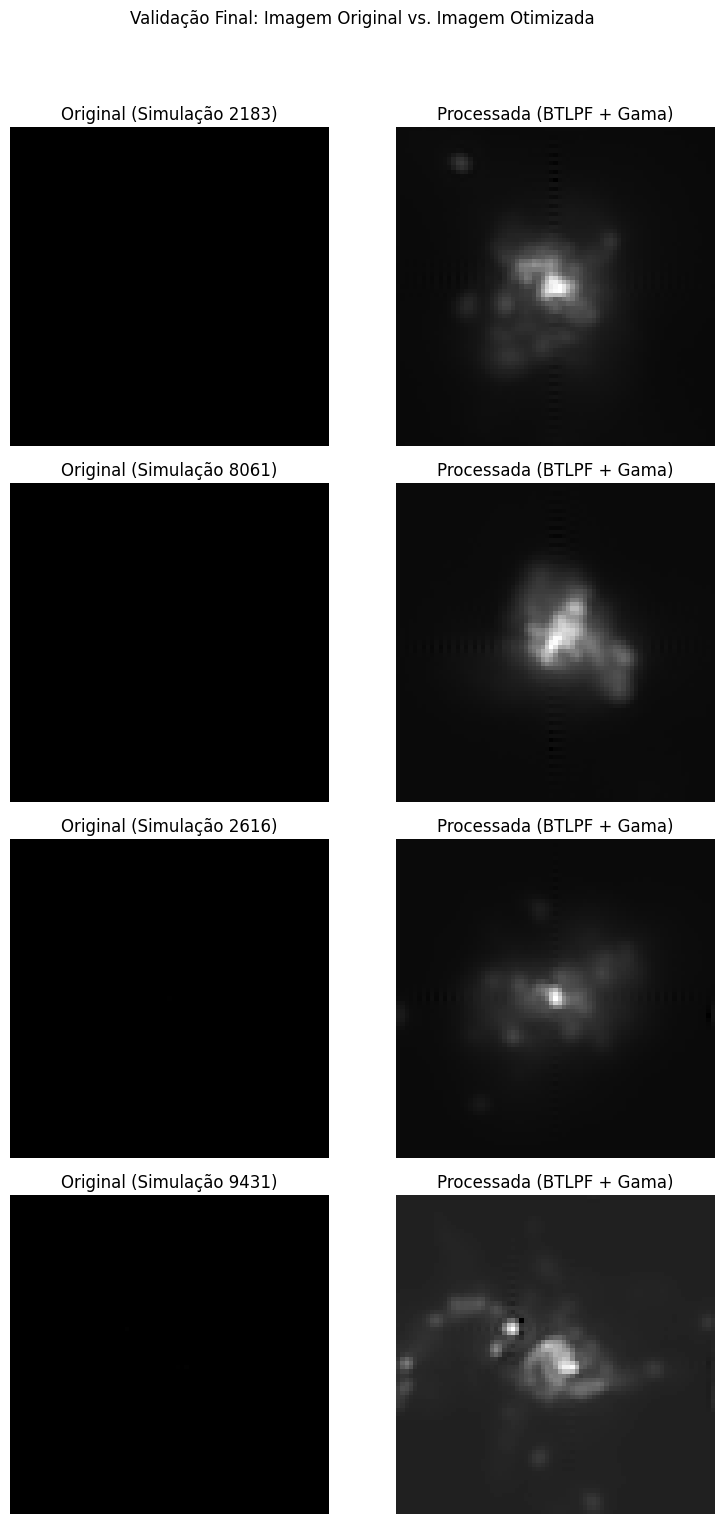

In [2]:
 plot_validation_final(selected_images, processed_images, n_plots=4)

Usando a Imagem Processada da Simulação 9013 como entrada.


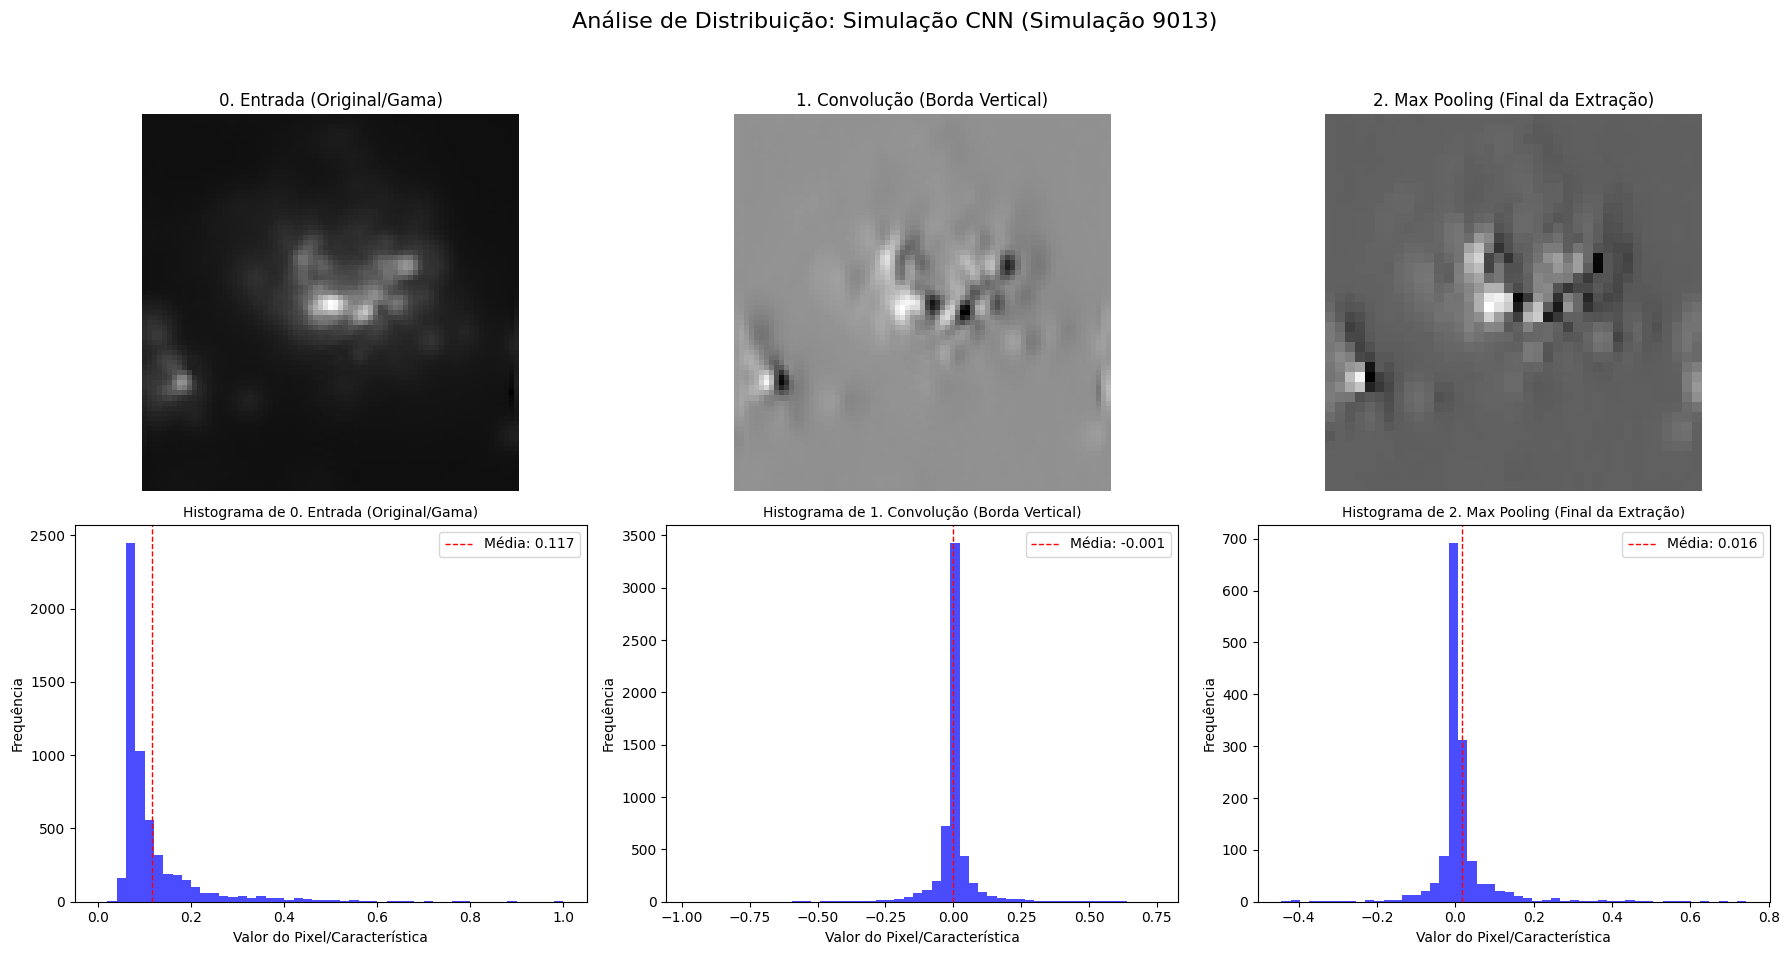


Os histogramas mostram como cada etapa de extração de características modifica a distribuição dos valores de pixel, essencialmente 'aprendendo' a representar diferentes padrões.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from skimage.measure import block_reduce 

# Supondo que 'processed_images' foi gerado corretamente na etapa anterior de PDS.
# Se você rodar este bloco isoladamente, substitua esta linha pelos seus dados:
# image_input = processed_images[SIMULATION_INDEX_TO_EXTRACT].astype(np.float64) 

# --- Exemplo de carregamento da imagem de teste (Simulação 9013) ---
# Vamos garantir que a imagem processada seja usada, selecionando o índice 9013, 
# se o array processed_images tiver sido criado.
try:
    # Tenta usar a imagem processada (índice 9013)
    SIM_INDEX = 9013 
    image_input = processed_images[SIM_INDEX].astype(np.float64)
    print(f"Usando a Imagem Processada da Simulação {SIM_INDEX} como entrada.")
except NameError:
    print("ERRO: O array 'processed_images' não está definido. Rodando com uma imagem de ruído para demonstração do HISTOGRAMA.")
    # Se 'processed_images' não existir (erro anterior), cria uma imagem escura como entrada simulada
    image_input = np.zeros((75, 75))
    image_input[35:45, 35:45] = 1.0 # Adiciona um bloco branco
    SIM_INDEX = "Exemplo"

# ==============================================================================
# 1. ETAPAS DA SIMULAÇÃO CNN
# ==============================================================================

# Kernel para realçar bordas verticais
kernel_vertical = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]])

# Convolução
output_vertical = convolve(image_input, kernel_vertical)

# Max Pooling 2x2
pool_output = block_reduce(output_vertical, block_size=(2, 2), func=np.max)

# ==============================================================================
# 2. PLOTAGEM COM HISTOGRAMAS (Análise da Distribuição de Características)
# ==============================================================================

# Lista de arrays e seus rótulos para o histograma
analysis_data = [
    (image_input.flatten(), '0. Entrada (Original/Gama)'),
    (output_vertical.flatten(), '1. Convolução (Borda Vertical)'),
    (pool_output.flatten(), '2. Max Pooling (Final da Extração)')
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.suptitle(f"Análise de Distribuição: Simulação CNN (Simulação {SIM_INDEX})", fontsize=16)

# --- Linha 1: Visualização dos Mapas ---
for i, (data_flat, title) in enumerate(analysis_data):
    ax = axes[0, i]
    # O reshape é necessário para plotar o mapa 2D (não o histograma)
    data_2d = data_flat.reshape(int(np.sqrt(data_flat.size)), -1) 
    
    ax.imshow(data_2d, cmap='gray')
    ax.set_title(title, fontsize=12)
    ax.axis('off')

# --- Linha 2: Histogramas (Análise da Distribuição de Valores) ---
for i, (data_flat, title) in enumerate(analysis_data):
    ax = axes[1, i]
    
    # Plota o histograma com 50 bins (caixas)
    ax.hist(data_flat, bins=50, color='blue', alpha=0.7)
    
    # Determina o valor médio (média) da característica extraída
    mean_val = np.mean(data_flat)
    ax.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Média: {mean_val:.3f}')
    
    ax.set_title(f'Histograma de {title}', fontsize=10)
    ax.set_xlabel('Valor do Pixel/Característica')
    ax.set_ylabel('Frequência')
    ax.legend()

# A LINHA ABAIXO FOI REMOVIDA/COMENTADA:
# axes[1, 3].axis('off') 

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("\nOs histogramas mostram como cada etapa de extração de características modifica a distribuição dos valores de pixel, essencialmente 'aprendendo' a representar diferentes padrões.")

In [6]:
import numpy as np
# Assumindo que 'pool_vertical' é o mapa de característica da saída da Camada 1, 
# gerado no código anterior.

# Dimensão do mapa de características (Ex: 37x37)
feature_map_shape = pool_vertical.shape 

# 1. Simulação do Flatten (Achatar o mapa 2D em um vetor 1D)
feature_vector = pool_vertical.flatten()

# 2. Exibição das dimensões
print("--- Resultado Final da Extração de Características (CNN) ---")
print(f"Dimensão do Mapa de Características (2D): {feature_map_shape}")
print(f"Dimensão do Vetor de Características (1D - Após Flatten): {feature_vector.shape}")
print(f"Primeiros 10 elementos do Vetor de Características:\n{feature_vector[:10]}")

# 3. Simulação da Camada Totalmente Conectada (FC)
# Se a CNN tivesse que classificar 4 tipos de galáxias (Espiral, Elíptica, Lente, Irregular):
N_CLASSES = 4 

# Criação dos pesos simulados para a camada FC (Ex: 1369 entradas x 4 saídas)
# Na prática, estes pesos seriam aprendidos durante o treinamento da CNN.
simulated_weights = np.random.rand(feature_vector.size, N_CLASSES)

# Cálculo do score (entrada na Camada FC * Pesos)
# Este resultado é o que a função Softmax usaria para calcular a probabilidade de cada classe.
# score = (vetor_caracteristica @ pesos)
classification_scores = feature_vector @ simulated_weights

print("\n--- Simulação da Camada de Classificação (Fully Connected) ---")
print(f"Número de classes de galáxias: {N_CLASSES}")
print(f"Scores de Classificação Simulados (Entrada para Softmax):\n{classification_scores}")

# Encontra a classe com o maior score
predicted_class_index = np.argmax(classification_scores)

print(f"Classe com maior score (Previsão Simulada): Classe {predicted_class_index}")

--- Resultado Final da Extração de Características (CNN) ---
Dimensão do Mapa de Características (2D): (38, 38)
Dimensão do Vetor de Características (1D - Após Flatten): (1444,)
Primeiros 10 elementos do Vetor de Características:
[-0.32309026  1.44668254  1.52376271  0.63963326  0.82182118  1.00179138
  1.2302031   0.26748253 -0.16432599  0.69650602]

--- Simulação da Camada de Classificação (Fully Connected) ---
Número de classes de galáxias: 4
Scores de Classificação Simulados (Entrada para Softmax):
[448.05754089 438.87111467 417.07895106 429.99994011]
Classe com maior score (Previsão Simulada): Classe 0
